In [1]:
#Mojo of reproducibility
import torch
import random
import numpy as np

def set_seed(seed):
  #PyTorch
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  #Numpy
  np.random.seed(seed)
  #Python_random
  random.seed(seed)
  #CuDNN (when using CUDA)
  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# import torch
import torch.nn as nn
import torch.nn.functional as F

from fan import FANLayer

class FAN_Classifier(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout_rate):
        super().__init__()
        
        # Define a list of layers
        self.layers = nn.ModuleList()
        
        # Define the first layer
        self.layers.append(nn.Linear(173, hidden_size))
        
        # Define the intermediate hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(FANLayer(hidden_size, hidden_size))
        
        # Final layer to output
        self.emo_output_layer = nn.Linear(hidden_size, 6)
        self.strength_output_layer = nn.Linear(hidden_size, 3)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self,x):
        # Pass through hidden layers
        for layer in self.layers:
            x = layer(x)
            x = self.dropout(x)
        # Output layers
        emo_output = self.emo_output_layer(x)
        strength_output = self.strength_output_layer(x)
                
        return emo_output, strength_output

In [3]:
# Create dataset
from torch.utils.data import Dataset

class voiceDataset(Dataset):
    def __init__(self, features, emotionLabels, strengthLabels):
        self.features = features
        self.emotionLabels = emotionLabels
        self.strengthLabels = strengthLabels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {'features':self.features[idx], 
                'emotionLabel':self.emotionLabels[idx], 
                'strengthLabel':self.strengthLabels[idx]
        }   


In [4]:
import pandas as pd
df = pd.read_csv('../data/featuresAndLabels.csv')

In [5]:
df.head()

,clipName,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,tonnets_172,N,A,D,F,S,H,low,medium,high
0,1022_ITS_ANG_XX,-625.058655,-4.994524,-5.040599,31.118151,-11.813456,-14.570557,0.724647,-9.413414,-3.972650,...,0.009466,0.000000,0.454545,0.545455,0.0,0.0,0.0,0.000000,0.272727,0.727273
1,1037_ITS_ANG_XX,-648.157227,-10.045857,7.429339,20.802429,-12.531164,-11.790744,-3.735406,-6.268928,-9.658600,...,0.032486,0.500000,0.200000,0.200000,0.1,0.0,0.0,0.000000,0.300000,0.700000
2,1060_ITS_NEU_XX,-565.523743,-29.746906,5.289134,20.724148,-6.095077,-11.757398,0.216888,-9.311358,-4.887557,...,0.003219,0.900000,0.000000,0.000000,0.0,0.1,0.0,0.000000,0.200000,0.800000
3,1075_ITS_NEU_XX,-556.091248,-15.240954,11.779830,20.665905,-9.193678,-11.914318,0.438259,-7.635978,-7.933719,...,0.001605,0.909091,0.000000,0.090909,0.0,0.0,0.0,0.181818,0.090909,0.727273
4,1073_IOM_DIS_XX,-622.589111,-13.248747,4.246189,30.263844,-10.529772,-10.335563,1.289759,-11.116067,-5.185853,...,0.040066,0.300000,0.000000,0.600000,0.0,0.1,0.0,0.200000,0.200000,0.600000


In [6]:
# Cut corresponding columns of df into features and labels
# Turn them into tensors
features = df.iloc[:, 1:174].values
features = torch.tensor(features, dtype=torch.float32)

emotionLabels = df.iloc[:,174:180].values
emotionLabels = torch.tensor(emotionLabels, dtype=torch.float32)

strengthLabels = df.iloc[:,180:183].values
strengthLabels = torch.tensor(strengthLabels, dtype=torch.float32)

Neutral:  4414
Anger:  1071
Disgust:  563
Fear:  677
Sad:  367
Happy:  350


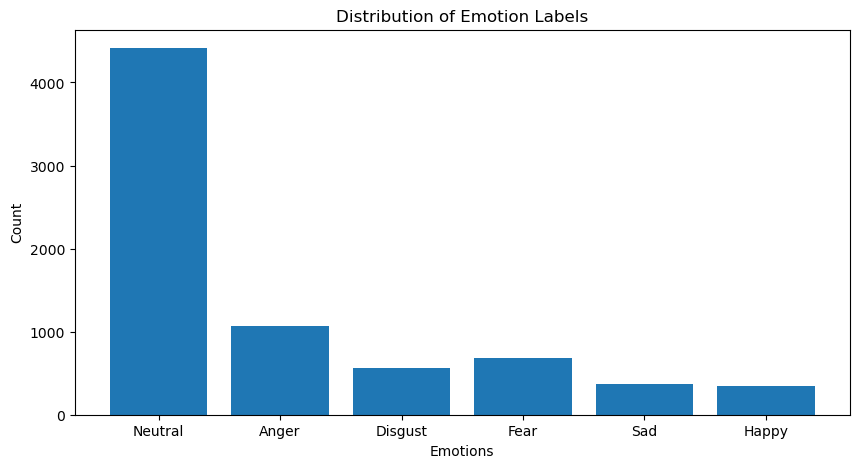

In [7]:
import matplotlib.pyplot as plt

#Check the distribution of emotion labels
neutralCount = 0
angerCount = 0
disgustCount = 0
fearCount = 0
sadCount = 0
happyCount = 0

for i in range(len(emotionLabels)):
    emotionLabel = torch.argmax(emotionLabels[i])
    if emotionLabel == 0:
        neutralCount += 1
    elif emotionLabel == 1:
        angerCount += 1
    elif emotionLabel == 2:
        disgustCount += 1
    elif emotionLabel == 3:
        fearCount += 1
    elif emotionLabel == 4:
        sadCount += 1
    elif emotionLabel == 5:
        happyCount += 1
        
print("Neutral: ", neutralCount)
print("Anger: ", angerCount)
print("Disgust: ", disgustCount)
print("Fear: ", fearCount)
print("Sad: ", sadCount)
print("Happy: ", happyCount)

plt.figure(figsize=(10, 5))
plt.bar(['Neutral', 'Anger', 'Disgust', 'Fear', 'Sad', 'Happy'],
        [neutralCount, angerCount, disgustCount, fearCount, sadCount, happyCount])
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels')
plt.show()

Low:  46
Medium:  1398
High:  5998


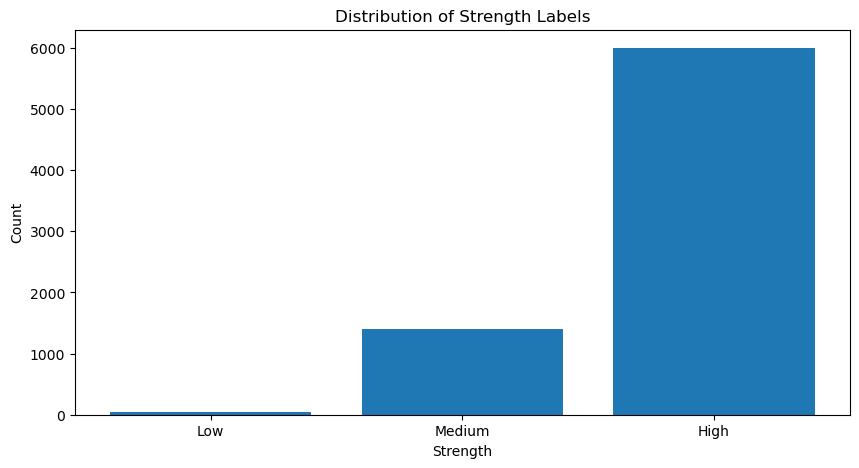

In [8]:
#Check the distribution of strength labels
lowCount = 0
mediumCount = 0
highCount = 0

for i in range(len(strengthLabels)):
    strengthLabel = torch.argmax(strengthLabels[i])
    if strengthLabel == 0:
        lowCount += 1
    elif strengthLabel == 1:
        mediumCount += 1
    elif strengthLabel == 2:
        highCount += 1

print("Low: ", lowCount)
print("Medium: ", mediumCount)
print("High: ", highCount)

plt.figure(figsize=(10, 5))
plt.bar(['Low', 'Medium', 'High'],
        [lowCount, mediumCount, highCount])
plt.xlabel('Strength')
plt.ylabel('Count')
plt.title('Distribution of Strength Labels')
plt.show()

In [9]:
# Create datasets
# train, validate, test = 8:1:1
train_size = int(0.8 * len(df))
val_size = int(0.05 * len(df))
test_size = len(df) - train_size - val_size

print(train_size, val_size, test_size)

train_dataset = voiceDataset(features[:train_size], 
                             emotionLabels[:train_size], 
                             strengthLabels[:train_size])

validate_dataset_1 = voiceDataset(features[train_size:train_size + val_size],
                                emotionLabels[train_size:train_size + val_size], 
                                strengthLabels[train_size:train_size + val_size])

validate_dataset_2 = voiceDataset(features[train_size + val_size:train_size + 2 * val_size],
                                emotionLabels[train_size + val_size:train_size + 2 * val_size], 
                                strengthLabels[train_size + val_size:train_size + 2 * val_size])

test_dataset = voiceDataset(features[train_size + val_size:],
                            emotionLabels[train_size + val_size:], 
                            strengthLabels[train_size + val_size:])


from torch.utils.data import DataLoader, WeightedRandomSampler

print(len(train_dataset),len(validate_dataset_1), len(validate_dataset_2), len(test_dataset))

#Create sampler to handle the class imbalance during the training
emotionLabelTensor_train = emotionLabels[:train_size]

#Get the distribution of the class (How many counts per class)
train_distribution = torch.bincount(emotionLabelTensor_train.argmax(dim=1))

print(train_distribution)
#Calculate the weights for each class (inverse of the distribution)
train_weights = 1./train_distribution
#Normalize the weights
train_weights /= train_weights.sum()

#Broadcast the weights to each sample 
train_sample_weights = train_weights[emotionLabelTensor_train.argmax(dim=1)]
#Create the weighted random sampler that load the data based on the weights
train_sampler = WeightedRandomSampler(weights=train_sample_weights,
                                      num_samples=len(train_sample_weights),
                                      replacement = True)
# Create dataLoader
trainDataLoader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler)
validationDataLoader_1 = DataLoader(validate_dataset_1,batch_size=128)
validationDataLoader_2 = DataLoader(validate_dataset_2,batch_size=128)
testDataLoader = DataLoader(test_dataset,batch_size=1)


5953 372 1117
5953 372 372 1117
tensor([3527,  861,  456,  539,  282,  288])


In [10]:
print(emotionLabelTensor_train.argmax(dim=1))

tensor([2, 0, 0,  ..., 0, 0, 2])


In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the trainer & validator function
def train_validate_model(hidden_size = 0,
                         num_layers = 0,
                         dropout_rate = 0, 
                         trainDataLoader = None, 
                         validationDataLoader = None,
                         num_epochs = 0, 
                         learning_rate = 0,
                        save = False):

    set_seed(42)

    #Get the GPU as a device if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Instantiate the model
    model = FAN_Classifier(hidden_size = hidden_size,
                           num_layers = num_layers,
                           dropout_rate = dropout_rate)

    # Moving the model to GPU if available
    model.to(device)

    #Prepare the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #Prepare the error function
    criterion = nn.KLDivLoss(reduction='batchmean')

    #Prepare the scheduler
    #Reduce the learning rate by 0.1 if the validation loss does not decrease for 3 epochs
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    #Prepare the DataLoader
    train_data_loader = trainDataLoader
    validation_data_loader = validationDataLoader

    #Placeholder for minimum validation loss
    min_val_loss = float('inf')

    for epoch in range(num_epochs):
        #set the model to training mode
        model.train()

        total_loss = 0 #Placeholder for training loss per epoch
        for batch in train_data_loader:
            feature = batch['features'].to(device)
            emotionLabel = batch['emotionLabel'].to(device)
            strengthLabel = batch['strengthLabel'].to(device)

            optimizer.zero_grad()
            emotionOutput, strengthOutput = model(feature)
            #Calculate the log-probabilities of the output
            emotionOutput_log = F.log_softmax(emotionOutput, dim=1)
            strengthOutput_log = F.log_softmax(strengthOutput, dim=1)
            
            #Calculate the loss for emotion head
            emo_loss = criterion(emotionOutput_log, emotionLabel)
            #Calculate the loss for strength head
            strength_loss = criterion(strengthOutput_log, strengthLabel)
            #Combine two losses to make a total loss. 
            #Put more weight on the emotion loss (7:3). Detecting emotion is more critical
            loss = 0.7*emo_loss + 0.3*strength_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        #Validate the model
        model.eval() #Set the model to evaluation mode
        with torch.no_grad():
            total_samples = 0 #Total output for accuracy calculation
            emoCorrect = 0 #Amount of correct prediction for accuracy calculation
            strengthCorrect = 0
            total_val_loss = 0 #Placeholder for validation loss per epoch
            
            for batch in validation_data_loader:
                feature = batch['features'].to(device)
                emotionLabel = batch['emotionLabel'].to(device)
                strengthLabel = batch['strengthLabel'].to(device)
                #Forward pass
                emotionOutput, strengthOutput = model(feature)
                #Calculate the log-probabilities of the output
                emotionOutput_log = F.log_softmax(emotionOutput, dim=1)
                strengthOutput_log = F.log_softmax(strengthOutput, dim=1)
                
                emo_loss = criterion(emotionOutput_log, emotionLabel)
                strength_loss = criterion(strengthOutput_log, strengthLabel )
                total_val_loss += 0.7*emo_loss + 0.3*strength_loss
                
                # Get predicted emotion class & target emotion class
                emo_predicted = torch.argmax(emotionOutput, dim=1)
                emo_target = torch.argmax(emotionLabel, dim=1)
                
                # Get predicted strength class & target emotion class
                strength_predicted = torch.argmax(strengthOutput,dim=1)
                strength_target = torch.argmax(strengthLabel, dim=1 )
                
                emoCorrect += (emo_predicted == emo_target).sum().item()
                strengthCorrect += (strength_predicted ==strength_target).sum().item()
                
                #Get total number of samples per epoch
                total_samples += emotionLabel.size(0)

            emo_accuracy = emoCorrect / total_samples
            strength_accuracy = strengthCorrect / total_samples


            #Print out the validation loss and accuracy per epoch
            # print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {total_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Accuracy (Emotion): {emo_accuracy:.4f}, Accuracy (Strength): {strength_accuracy}")

            #pass the validation loss to the scheduler
            scheduler.step(total_val_loss)

        #If fineTuning = False, save the model with the lowest validation loss
        #Save the first epoch model just in case

            if epoch == 0:
                min_val_loss = total_val_loss #Instantiate the min_val_loss at the first epoch
                if save == True:
                    torch.save(model.state_dict(), 'bestFAN.pth')
            #Save the model if the validation loss is the lowest
            elif total_val_loss < min_val_loss:
                min_val_loss = total_val_loss
                if save == True:
                    torch.save(model.state_dict(), 'bestFAN.pth')
                    print(f"Model saved after Epoch: {epoch+1}")
                        

    #Return the minimum validation loss for hyperparameter tuning
    return min_val_loss

In [12]:
import optuna

def objective(trial):

    set_seed(42)

    #Define the hyperparameters to be tuned
    #Dimension of the hidden layer 
    hidden_size = trial.suggest_int('hidden_size', 52, 100, step=4)
    #Number of layers
    num_layers = trial.suggest_int('num_layers', 5, 15)
    #Dropout rate for the final feedforward network [0.1, 0.5]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    #Number of epochs [10, 30]
    num_epochs = trial.suggest_int('num_epochs', 10, 30)
    #Learning rate for the optimizer [1e-5, 1e-3]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3)

    result = train_validate_model(hidden_size = hidden_size,
                                  num_layers = num_layers,
                                  dropout_rate = dropout_rate,
                                  trainDataLoader = trainDataLoader,
                                  validationDataLoader = validationDataLoader_1,
                                  num_epochs = num_epochs,
                                  learning_rate = learning_rate,
                                  save = False
                                  )

    return result


/Users/takehararyoutarou/anaconda3/envs/mlVenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value (Validation Loss): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-10 18:42:33,155] A new study created in memory with name: no-name-7638e533-d41f-4f9f-a655-24488eea4399
/Users/takehararyoutarou/anaconda3/envs/mlVenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-04-10 18:42:36,503] Trial 0 finished with value: 1.7284876108169556 and parameters: {'hidden_size': 68, 'num_layers': 8, 'dropout_rate': 0.2955925040853857, 'num_epochs': 11, 'learning_rate': 0.0003528700253967739}. Best is trial 0 with value: 1.7284876108169556.
[I 2025-04-10 18:42:38,677] Trial 1 finished with value: 3.3111515045166016 and parameters: {'hidden_size': 64, 'num_layers': 6, 'dropout_rate': 0.20968128860016233, 'num_epochs': 16, 'learning_rate': 3.6267576233185886e-05}. Best is trial 0 with value: 1.7284876108169556.
[I 2025-04-10 18:42:42,439] Trial 2 finished with value: 2.174978733062744 and parameters: {'hidden_size': 84, 

Best trial:
  Value (Validation Loss): 1.5959542989730835
  Params: 
    hidden_size: 96
    num_layers: 13
    dropout_rate: 0.34784019385980275
    num_epochs: 21
    learning_rate: 0.0007071799043468824


In [14]:
print(trial.params)

{'hidden_size': 96, 'num_layers': 13, 'dropout_rate': 0.34784019385980275, 'num_epochs': 21, 'learning_rate': 0.0007071799043468824}


In [15]:
best_hidden_size = trial.params['hidden_size']
best_num_layers = trial.params['num_layers']
best_dropout_rate = trial.params['dropout_rate']
best_num_epochs = trial.params['num_epochs']
best_learning_rate = trial.params['learning_rate']

In [16]:
# Merge the training and validation dataset 1 to train the final model
final_train_dataset = voiceDataset(features[:train_size + val_size],
                                    emotionLabels[:train_size + val_size], 
                                    strengthLabels[:train_size + val_size])

final_trainDataLoader = DataLoader(final_train_dataset, batch_size=128, shuffle=True)

result = train_validate_model(hidden_size = best_hidden_size,
                                  num_layers = best_num_layers,
                                  dropout_rate = best_dropout_rate,
                                  trainDataLoader = final_trainDataLoader,
                                  #Use validationDataLoader_2 for the early stopping of the final model
                                  validationDataLoader = validationDataLoader_2,
                                  num_epochs = best_num_epochs,
                                  learning_rate = best_learning_rate,
                                  save = True
                                  )

Model saved after Epoch: 2
Model saved after Epoch: 3
Model saved after Epoch: 5
Model saved after Epoch: 6
Model saved after Epoch: 13
Model saved after Epoch: 16


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bestModel = FAN_Classifier(
                       hidden_size = best_hidden_size,
                       num_layers = best_num_layers,
                       dropout_rate = best_dropout_rate,
                       )

bestModel.load_state_dict(torch.load('bestFAN.pth',map_location=device))

bestModel.eval() #Set the bestModel to evaluation mode
bestModel.to(device)

with torch.no_grad():
  total = 0 #Total output for accuracy calculation
  emoCorrect = 0 #Amount of correct prediction for accuracy calculation
  strengthCorrect = 0
  emoPredList = [] #Placeholder for the predicted labels
  emoTargetList = [] #Placeholder for the target labels
  strengthPredList = []
  strengthTargetList = []
  
  for batch in testDataLoader:
      feature = batch['features'].to(device)
      emoLabel = batch['emotionLabel'].to(device)
      strengthLabel = batch['strengthLabel'].to(device)
      
      emoOutput, strengthOutput = bestModel(feature)
      
      emoPredicted = torch.argmax(emoOutput, dim = 1)
      emoTarget = torch.argmax(emoLabel, dim=1)
      
      emoPredList.append(emoPredicted.cpu().numpy())
      emoTargetList.append(emoTarget.cpu().numpy())
      
      strengthPredicted = torch.argmax(strengthOutput, dim=1)
      strengthTarget = torch.argmax(strengthLabel, dim=1)
      
      strengthPredList.append(strengthPredicted.cpu().numpy())
      strengthTargetList.append(strengthTarget.cpu().numpy())
      
      total += emoLabel.size(0)
      emoCorrect += (emoPredicted == emoTarget).sum().item()
      strengthCorrect += (strengthPredicted == strengthTarget).sum().item()
      
  print(f"Emotion Accuracy: {emoCorrect/total:.4f}")
  print(f"Strength Accuracy: {strengthCorrect/total:.4f}")


/var/folders/3y/2jj6w99n11g766vg19kpr73h0000gn/T/ipykernel_48186/3292993192.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestModel.load_state_dict(torch.load('bestFA

Emotion Accuracy: 0.5882
Strength Accuracy: 0.8183


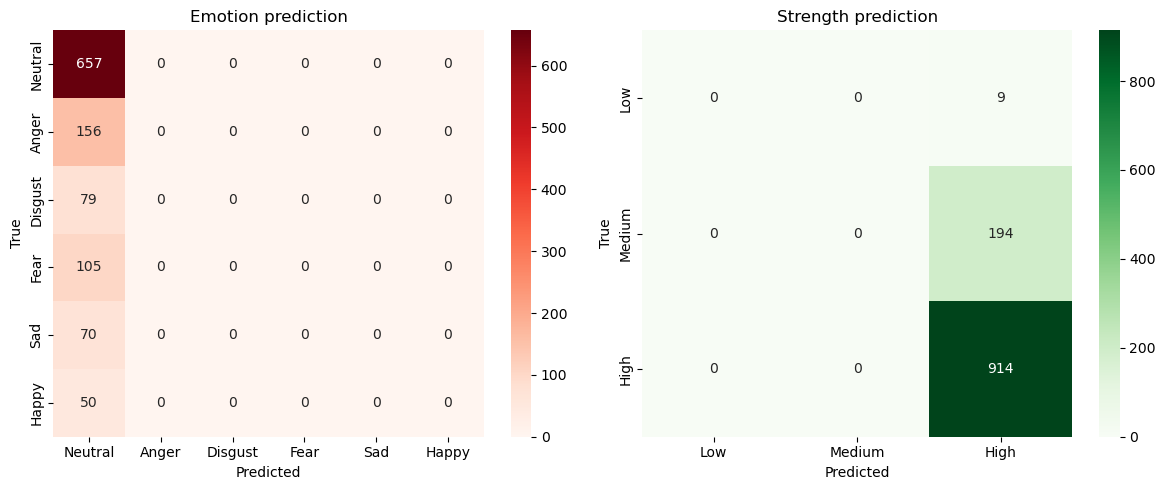

In [18]:
# Print out the confusion matrix  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_emo = confusion_matrix(emoTargetList, emoPredList)
cm_strength = confusion_matrix(strengthTargetList, strengthPredList)

emo_label = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Sad', 'Happy']
strength_label = ['Low', 'Medium', 'High']

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot
sns.heatmap(cm_emo, annot=True, fmt='d', cmap='Reds',
            xticklabels=emo_label, yticklabels=emo_label, ax=axes[0])
axes[0].set_title('Emotion prediction')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Right plot
sns.heatmap(cm_strength, annot=True, fmt='d', cmap='Greens',
            xticklabels=strength_label, yticklabels=strength_label, ax=axes[1])
axes[1].set_title('Strength prediction')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()
